In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl

In [2]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [3]:
import tensorflow as tf
from tensorflow import keras

BATCH_SIZE = 100000
samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["solved", "interrupted"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(["solved", "interrupted"])

Found 199898 files belonging to 2 classes.
Using 159919 files for training.


2023-10-18 19:08:48.914624: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-18 19:08:48.914681: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-18 19:08:48.914685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-18 19:08:48.914925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-18 19:08:48.915164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 199898 files belonging to 2 classes.
Using 39979 files for validation.


In [4]:
for X,y in train_dataset.take(1):
    pass

In [5]:
y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
y = y == 1

In [6]:
print(X.numpy().astype(str)[0])

dataset: B
instance: TA2
+-----------+
2D Packing MIP with Time Limit 2 [s] in Truck P342368603
Stack 0 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 1 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 2 with items: ['0090038300_26102022001330']
Stack 3 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 4 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 5 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 6 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 7 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 8 with items: ['0090038300_26102022004784', '0090038300_26102022004784']
Stack 9 with items:

In [7]:
X = X.numpy().astype(str)
df = pl.DataFrame({"raw": X})
print(df[0, 0])

dataset: B
instance: TA2
+-----------+
2D Packing MIP with Time Limit 2 [s] in Truck P342368603
Stack 0 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 1 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 2 with items: ['0090038300_26102022001330']
Stack 3 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 4 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 5 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 6 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 7 with items: ['0090038300_26102022001330', '0090038300_26102022001330', '0090038300_26102022001330']
Stack 8 with items: ['0090038300_26102022004784', '0090038300_26102022004784']
Stack 9 with items:

# Processing functions:

## Extract raw data

In [8]:
def extract_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extracts features via regex from raw txt-file input.
    Drops rows which dont contain a truck_id or 3D packing instances
    """
    df = df.with_columns([
        pl.Series(name="index", values=np.arange(len(df.collect()))),
        #pl.Series(name="index", values=np.arange(len(df))),
        pl.col("raw").str.extract("in Truck (\w\d{9})\n").alias("truck_id"),
        pl.col("raw").str.extract("dataset: (\w*)\n").alias("dataset"),
        pl.col("raw").str.extract("instance: ([A-Z0-9]*)\n").alias("instance"),
    ])
    
    return df


In [9]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .collect()
    .head()
)

raw,index,truck_id,dataset,instance
str,i64,str,str,str
"""dataset: B ins…",0,"""P342368603""","""B""","""TA2"""
"""dataset: A ins…",1,"""P242037705""","""A""","""MA2"""
"""dataset: A ins…",2,"""P237037705""","""A""","""MA"""
"""dataset: B ins…",3,"""P344404207""","""B""","""CI"""
"""dataset: X ins…",4,"""P200056815""","""X""","""SA6"""


## Explode instance into stacks:

In [10]:
def explode_instances_into_stacks(df: pl.LazyFrame) -> pl.DataFrame:
    """
    Use regex to extract all stacks made of item ids, and explode df
    into rows of stacks, belonging to an instance.
    """
    
    df = (
        df.with_columns([
            pl.col("raw").str.extract_all("Stack \d* with items: (\[.*\])\n").alias("stacks")
        ])
          .drop(["raw"])
          .explode(columns = ["stacks"])\
          .with_columns([
              pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
              pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
          ])
    )
    return df


In [11]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stacks,stack_id,item_id
i64,str,str,str,str,i64,list[str]
0,"""P342368603""","""B""","""TA2""","""Stack 0 with i…",0,"[""0090038300_26102022001330"", ""0090038300_26102022001330"", ""0090038300_26102022001330""]"
0,"""P342368603""","""B""","""TA2""","""Stack 1 with i…",1,"[""0090038300_26102022001330"", ""0090038300_26102022001330"", ""0090038300_26102022001330""]"
0,"""P342368603""","""B""","""TA2""","""Stack 2 with i…",2,"[""0090038300_26102022001330""]"
0,"""P342368603""","""B""","""TA2""","""Stack 3 with i…",3,"[""0090038300_26102022001330"", ""0090038300_26102022001330"", ""0090038300_26102022001330""]"
0,"""P342368603""","""B""","""TA2""","""Stack 4 with i…",4,"[""0090038300_26102022001330"", ""0090038300_26102022001330"", ""0090038300_26102022001330""]"


## Explode stacks into items:

In [12]:
def explode_stacks_into_items(df: pl.DataFrame) -> pl.DataFrame:
    """
    Use regex to identify a stack and explode it into items,
    belonging to a stack, which again belongs to an instance.
    """
    df = df.with_columns([
        pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
        pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
    ]).drop("stacks").explode("item_id")\
    
    return df

In [13]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .collect()
    #.head()
)

index,truck_id,dataset,instance,stack_id,item_id
i64,str,str,str,i64,str
0,"""P342368603""","""B""","""TA2""",0,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",0,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",0,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",1,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",1,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",1,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",2,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",3,"""0090038300_261…"
0,"""P342368603""","""B""","""TA2""",3,"""0090038300_261…"


## Load and Merge Items

In [14]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
90016100,"""K11""",90016900,"""GRD1""","""100019127R""","""MFM---0474""",2.3,1.6,1.0,1.5736,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.955
26743100,null,90016900,"""169GB-10""","""8200658549""","""SLI---2112""",1.206,1.01,0.285,0.03433,0.0,"""C""","""BY""","""0090016900_270…",false,false,0.285
2695000,null,90016900,"""GRF1""","""271002239R""","""ECM---6655""",2.4,1.2,0.76,0.243,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.715
679301,null,90016900,"""169GB-20""","""8200689547""","""MTEM--4632""",1.8,1.2,2.34,0.550536,0.045,"""C""","""BY""","""0090016900_270…",false,false,2.295
679301,null,90016900,"""169GB-20""","""821009831R""","""MTEM--4633""",1.8,1.2,2.34,0.551344,0.045,"""C""","""BY""","""0090016900_270…",false,false,2.295


In [15]:
def join_items(df: pl.DataFrame, items) -> pl.DataFrame:
    """
    Perform a simple left join to add item level info.
    
    Validation sadly not supported for multiple keys (yet?)
    """
    
    return df.join(items, how = "left", on = ["dataset", "instance", "item_id"])

In [16]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stack_id,item_id,Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,ForcedLength,ForcedWidth,NestedHeight
i64,str,str,str,i64,str,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,bool,bool,f64
0,"""P342368603""","""B""","""TA2""",0,"""0090038300_261…",26064702,null,90038300,"""383G4B""","""546119919R""","""CAR-S*2991""",1.14,0.98,0.86,0.338,0.0,false,false,0.86
0,"""P342368603""","""B""","""TA2""",0,"""0090038300_261…",26064702,null,90038300,"""383G4B""","""546119919R""","""CAR-S*2991""",1.14,0.98,0.86,0.338,0.0,false,false,0.86
0,"""P342368603""","""B""","""TA2""",0,"""0090038300_261…",26064702,null,90038300,"""383G4B""","""546119919R""","""CAR-S*2991""",1.14,0.98,0.86,0.338,0.0,false,false,0.86
0,"""P342368603""","""B""","""TA2""",1,"""0090038300_261…",26064702,null,90038300,"""383G4B""","""546119919R""","""CAR-S*2991""",1.14,0.98,0.86,0.338,0.0,false,false,0.86
0,"""P342368603""","""B""","""TA2""",1,"""0090038300_261…",26064702,null,90038300,"""383G4B""","""546119919R""","""CAR-S*2991""",1.14,0.98,0.86,0.338,0.0,false,false,0.86


## Group by stack ID:

In [17]:
def group_items_by_stack(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group item level into back into a stack
    
    - Note that the Width and Length are the same for all items
    - Weight and Height have to be summed up, correcting for nesting height
    - forcedOrientation of a single item makes the whole stack oriented
    - Include Logistics info for stop differentation down the road
    
    """
    
    df = df.group_by(["index", "dataset", "instance", "truck_id", "stack_id"],
                    maintain_order = True)\
    .agg([
        pl.count("item_id").alias("items"),
        pl.max("Length"),
        pl.max("Width"),
        pl.sum("NestedHeight"),
        pl.last("Nesting height"),
        pl.sum("Weight"),
        pl.any("ForcedLength"),
        pl.any("ForcedWidth"),
        # Logistic order info
        pl.first("Supplier code"),
        pl.first("Supplier dock"),
        pl.first("Plant dock")
    ]).sort(["index", "stack_id"]).drop(["stack_id"])

    return df

In [18]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
# (507_770, 7)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",1,1.14,0.98,0.86,0.0,0.338,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",2,1.14,0.98,1.72,0.0,0.9676,false,false,27368600,null,"""383G2B"""


# Data Vis:

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",
        style="darkgrid")

In [20]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",1,1.14,0.98,0.86,0.0,0.338,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",3,1.14,0.98,2.58,0.0,1.014,false,false,26064702,null,"""383G4B"""
0,"""B""","""TA2""","""P342368603""",2,1.14,0.98,1.72,0.0,0.9676,false,false,27368600,null,"""383G2B"""


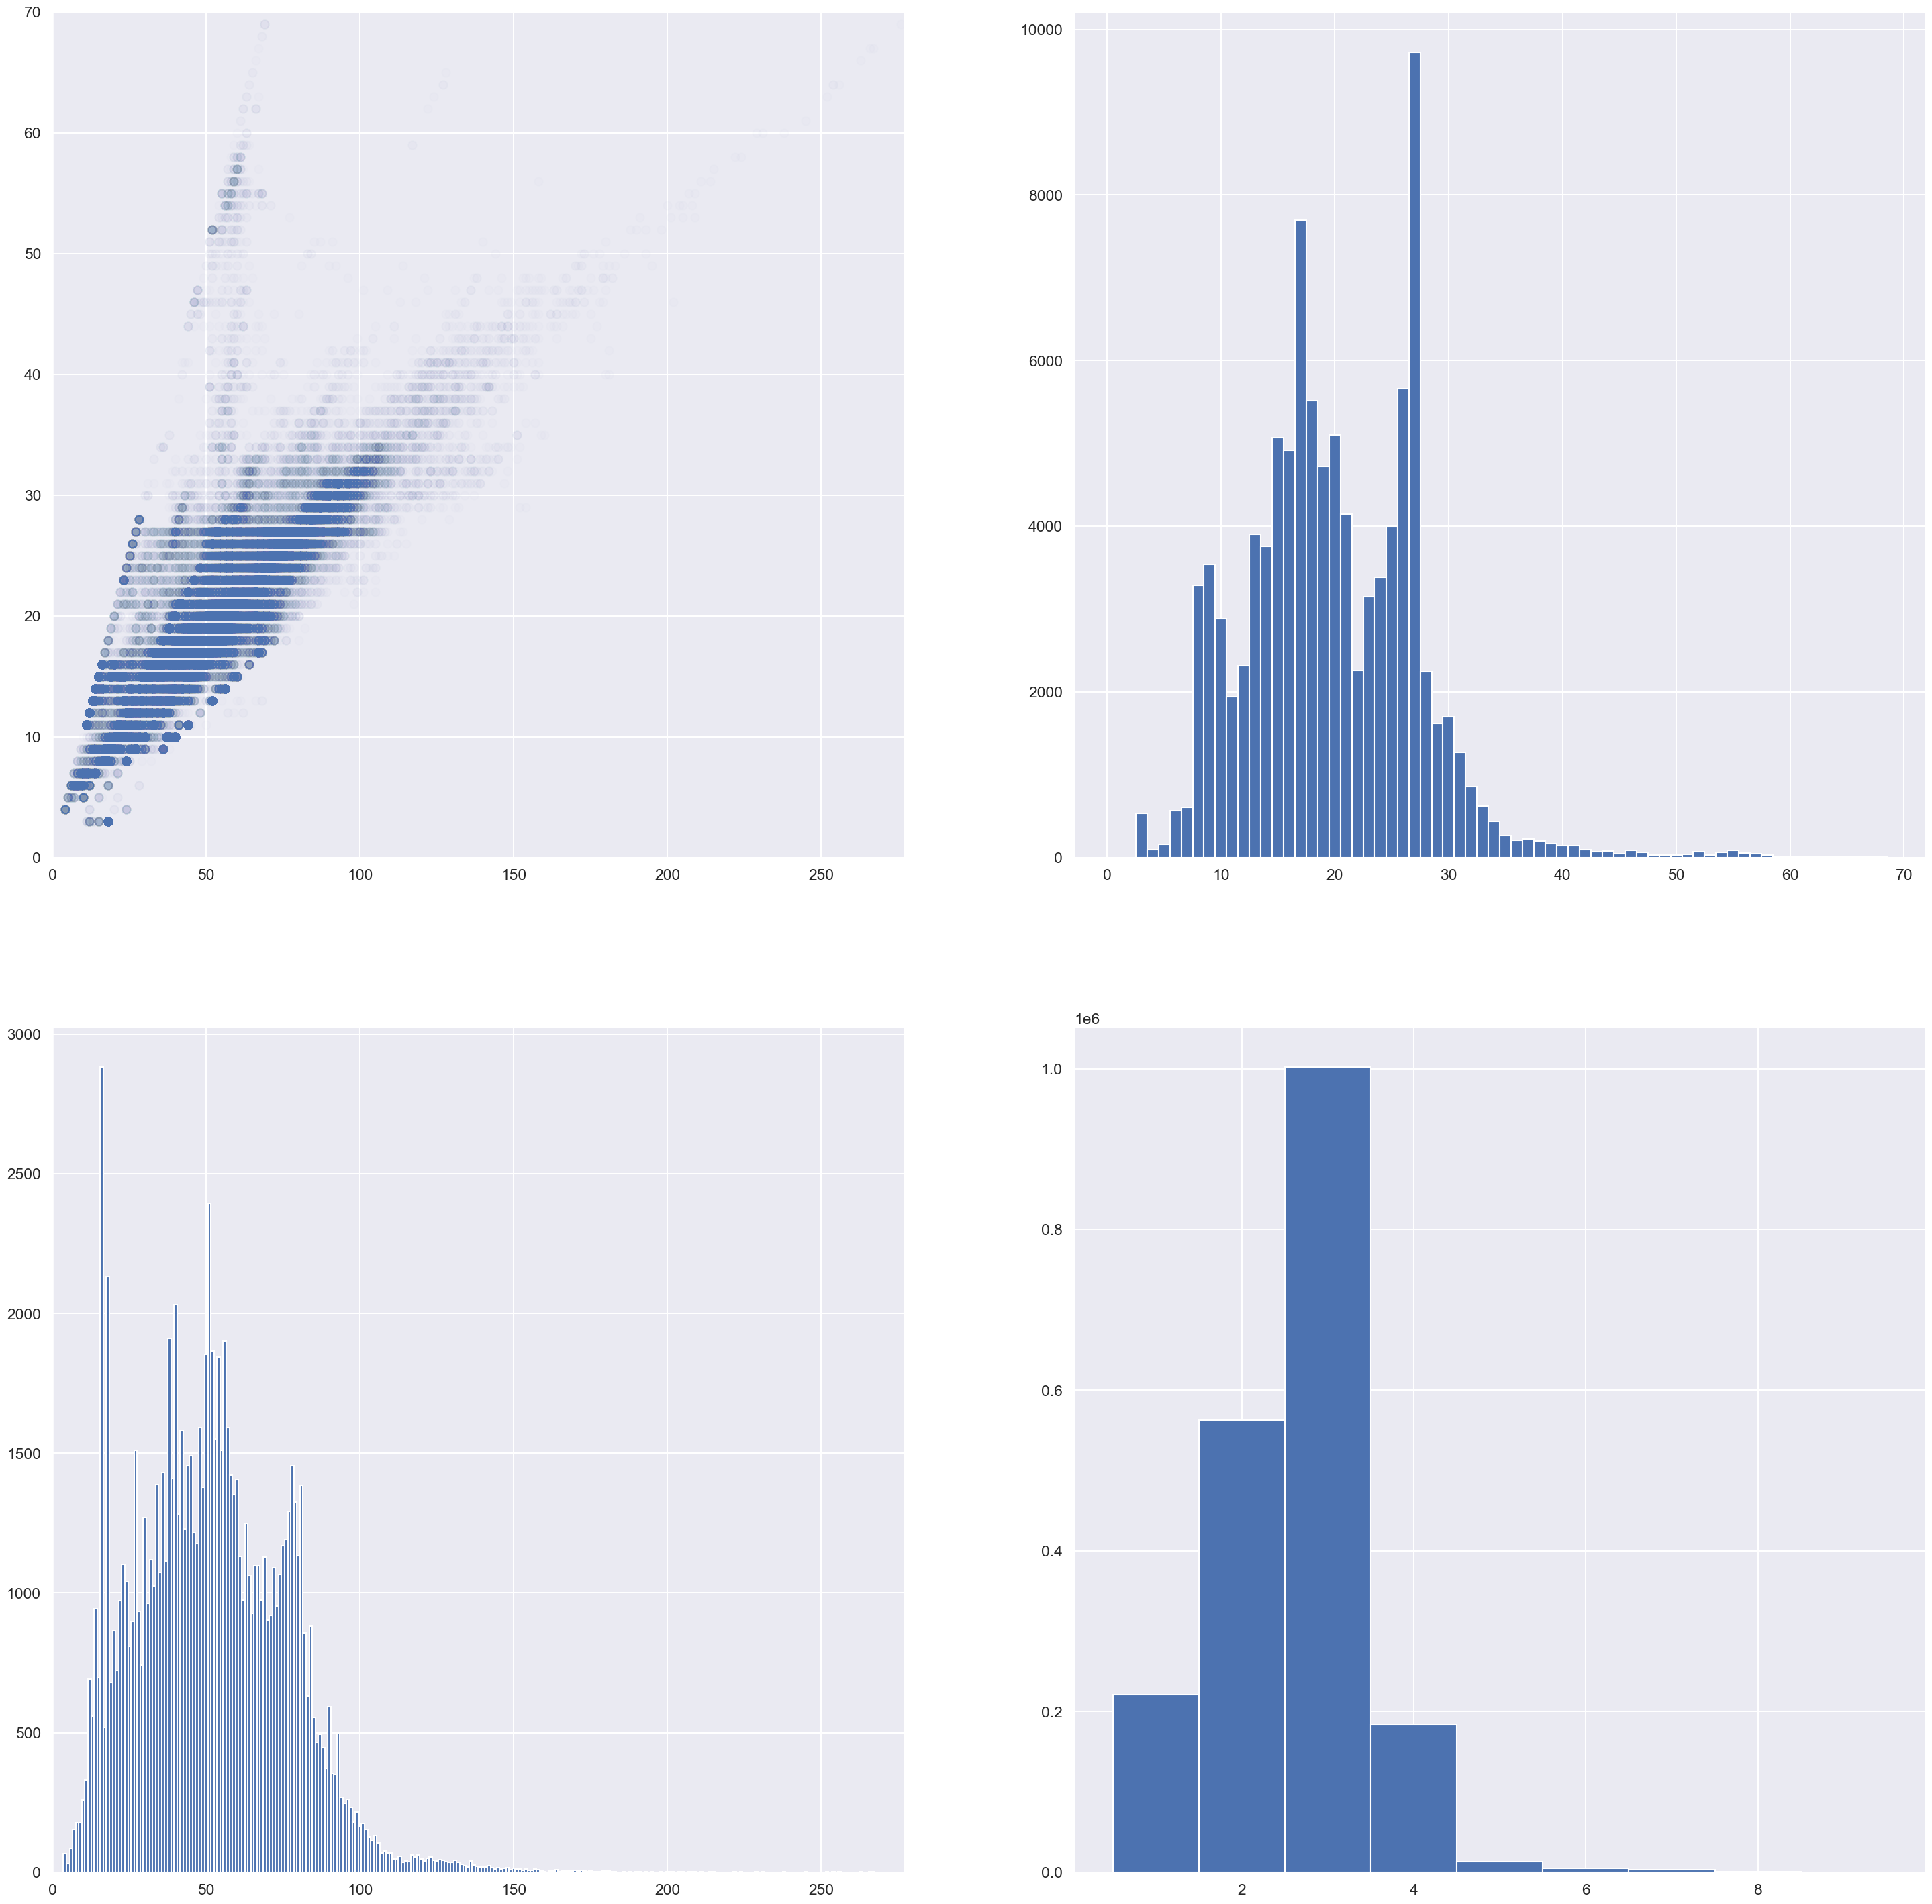

In [21]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

item_max = x.max()[0, "total_items"]
stack_max = x.max()[0, "total_stacks"]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))



ax[0, 0].scatter(
    y=x["total_stacks"],
    x=x["total_items"],
    #c = y.numpy(),
    alpha = 0.01
);
ax[0, 0].set(xlim=[0, item_max+1])
ax[0, 0].set(ylim=[0, stack_max+1])

ax[0, 1].hist(x["total_stacks"], bins=np.arange(0, stack_max, 1)+0.5)

ax[1, 0].hist(x["total_items"], bins=np.arange(0, item_max, 1)+0.5)
ax[1, 0].set(xlim=[0, item_max+1])



x = X["items"].to_numpy()
ax[1, 1].hist(x, bins=np.arange(0, 10, 1)+0.5);


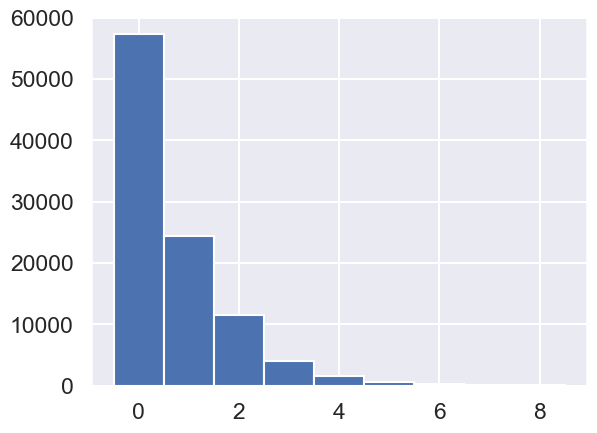

In [22]:
# Number of MIP Improvements:
x = df["raw"].str.extract_all("MIP Improvement (-)").list.len().to_pandas()
x = x-1
x.hist(bins = np.arange(0, 10, 1)-0.5);

raw
list[str]
"[""MIP Improvement - 2D Vol: 24.5784 [m2] - packed 2D Vol Ratio: 0.7461566484517305 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 26.8128 [m2] - packed 2D Vol Ratio: 0.8139890710382514 [%] - after 0.18016600608825684 [s]"", ""MIP Improvement - 2D Vol: 27.93 [m2] - packed 2D Vol Ratio: 0.8479052823315119 [%] - after 0.5861095110885799 [s]""]"
"[""MIP Improvement - 2D Vol: 20.34 [m2] - packed 2D Vol Ratio: 0.6174863387978142 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 28.38306 [m2] - packed 2D Vol Ratio: 0.8616593806921676 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 28.3831 [m2] - packed 2D Vol Ratio: 0.8616605950212508 [%] - after 0.026486873626708984 [s]""]"
"[""MIP Improvement - 2D Vol: 31.3397 [m2] - packed 2D Vol Ratio: 0.9514177292046145 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 29.808 [m2] - packed 2D Vol Ratio: 0.9049180327868853 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 30.76234 [m2] - packed 2D Vol Ratio: 0.9338901032179721 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 31.5072 [m2] - packed 2D Vol Ratio: 0.9565027322404372 [%] - after 3.210469961166382 [s]"", ""MIP Improvement - 2D Vol: 31.50722 [m2] - packed 2D Vol Ratio: 0.9565033394049788 [%] - after 7.7850706479512155 [s]""]"
"[""MIP Improvement - 2D Vol: 23.2092 [m2] - packed 2D Vol Ratio: 0.7045901639344263 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 24.1692 [m2] - packed 2D Vol Ratio: 0.7337340619307833 [%] - after 5.247258186340332 [s]"", … ""MIP Improvement - 2D Vol: 26.0892 [m2] - packed 2D Vol Ratio: 0.7920218579234973 [%] - after 12.405109167098999 [s]""]"
"[""MIP Improvement - 2D Vol: 31.2 [m2] - packed 2D Vol Ratio: 0.947176684881603 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 30.68732 [m2] - packed 2D Vol Ratio: 0.9316126290224651 [%] - after 0.0 [s]""]"


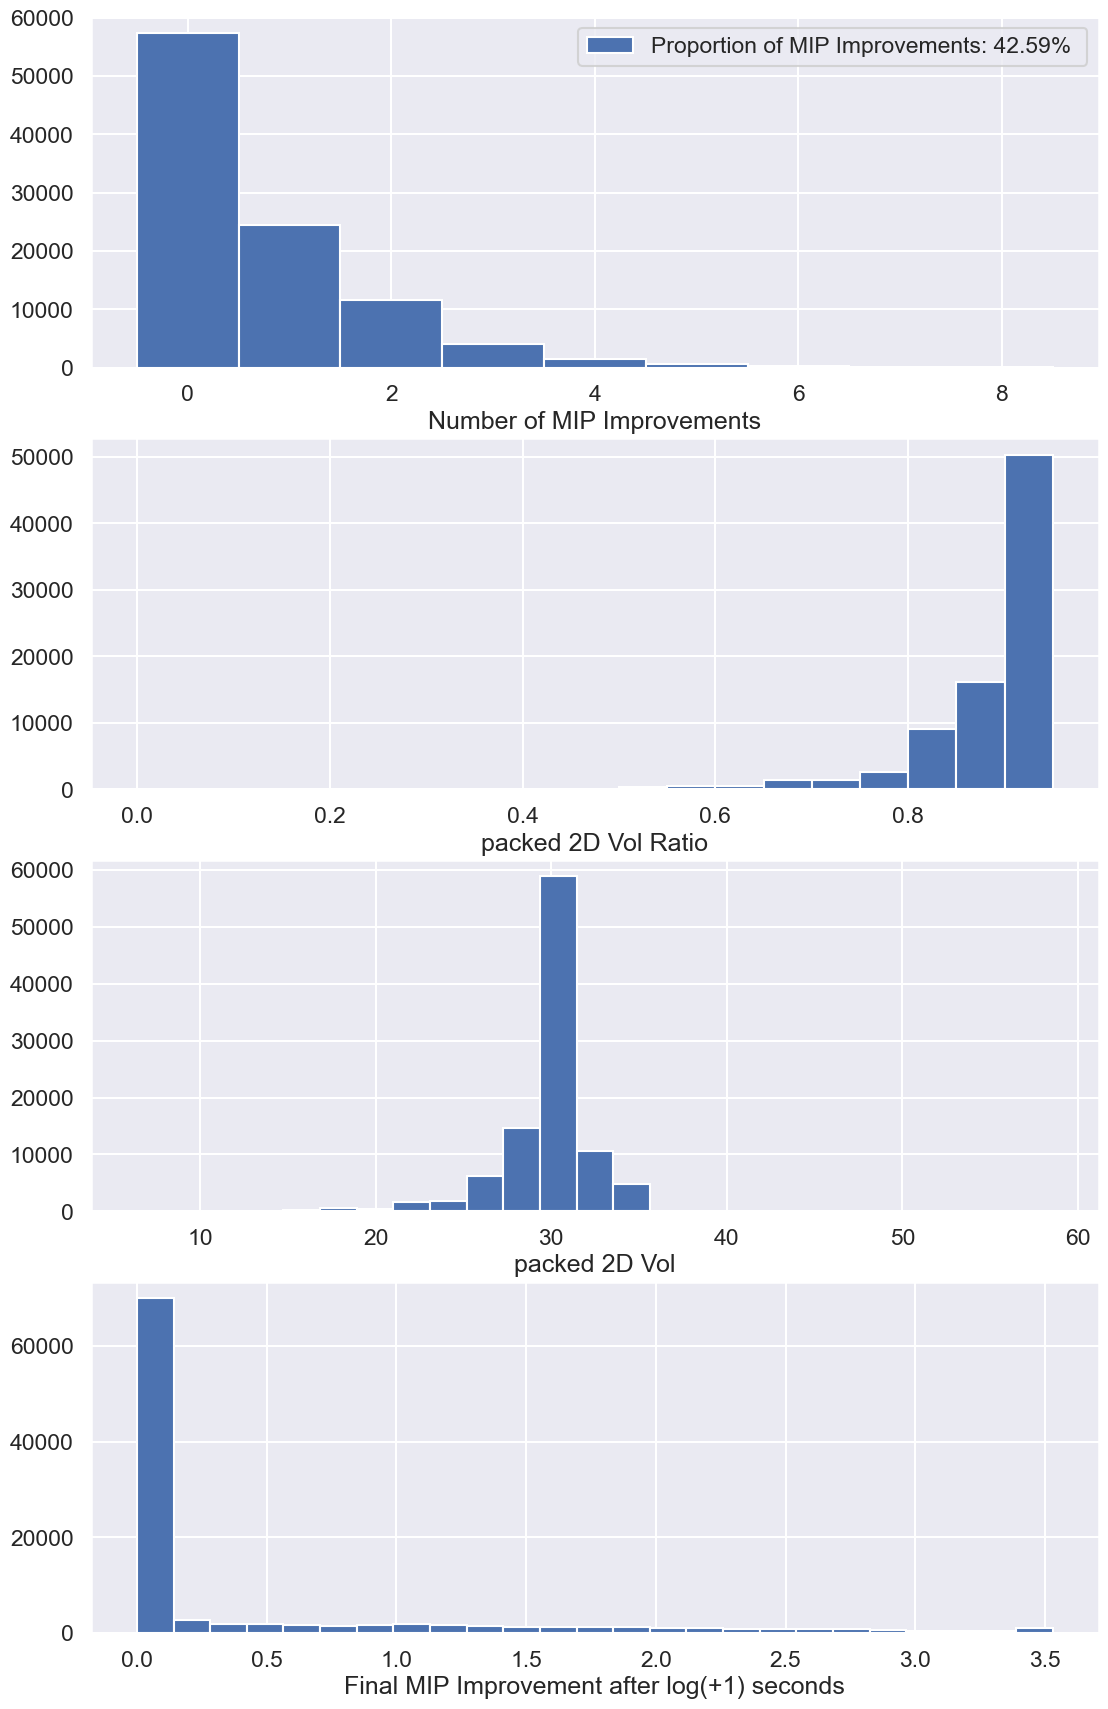

In [26]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

fig, ax = plt.subplots(4, figsize = (13, 21))

y_num_improvements = mip_improvements.list.len()-1
ax[0].hist(y_num_improvements, bins = np.arange(0, 10, 1)-0.5,
           label=f"Proportion of MIP Improvements: {(y_num_improvements>0).mean():.2%} ");
ax[0].set(xlabel="Number of MIP Improvements")

y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
ax[1].hist(y_packed_area_ratio, bins = np.arange(0, 1, 0.05));
ax[1].set(xlabel="packed 2D Vol Ratio")

#ax[2].hist((y_packed_area_ratio)**10, bins = 25);
#ax[2].set(xlabel="packed 2D Vol Ratio to the power 10")

y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
ax[2].hist(y_packed_area, bins = 25);
ax[2].set(xlabel="packed 2D Vol")


y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)
ax[3].hist(np.log1p(y_last_update), bins = 25);
ax[3].set(xlabel="Final MIP Improvement after log(+1) seconds")


ax[0].legend()

mip_improvements

In [30]:
print(df[1,0])

dataset: A
instance: MA2
+-----------+
2D Packing MIP with Time Limit 3.247914810492878 [s] in Truck P242037705
Stack 0 with items: ['0090016200_03072022015369', '0090016200_03072022015197']
Stack 1 with items: ['0090016200_03072022006455', '0090016200_03072022006455']
Stack 2 with items: ['0090016200_03072022006455', '0090016200_03072022006455']
Stack 3 with items: ['0090016200_03072022006455', '0090016200_03072022000950']
Stack 4 with items: ['0090016200_03072022000950', '0090016200_03072022000950']
Stack 5 with items: ['0090016200_03072022000950', '0090016200_03072022000950']
Stack 6 with items: ['0090016200_03072022011143', '0090016200_03072022011143']
Stack 7 with items: ['0090016200_03072022011143', '0090016200_03072022011143']
Stack 8 with items: ['0090016200_03072022011143', '0090016200_03072022011143']
MIP Improvement - 2D Vol: 20.34 [m2] - packed 2D Vol Ratio: 0.6174863387978142 [%] - after 0.0 [s] without stacks:
Stack 4 missing: ['0090016200_03072022000950', '0090016200_030

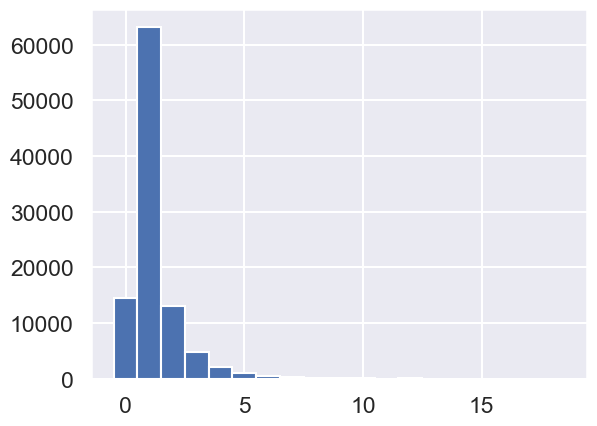

In [43]:
pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
plt.hist(x.list.len(), bins=np.arange(0, 20, 1)-0.5);
#Number of missing items in final solution:

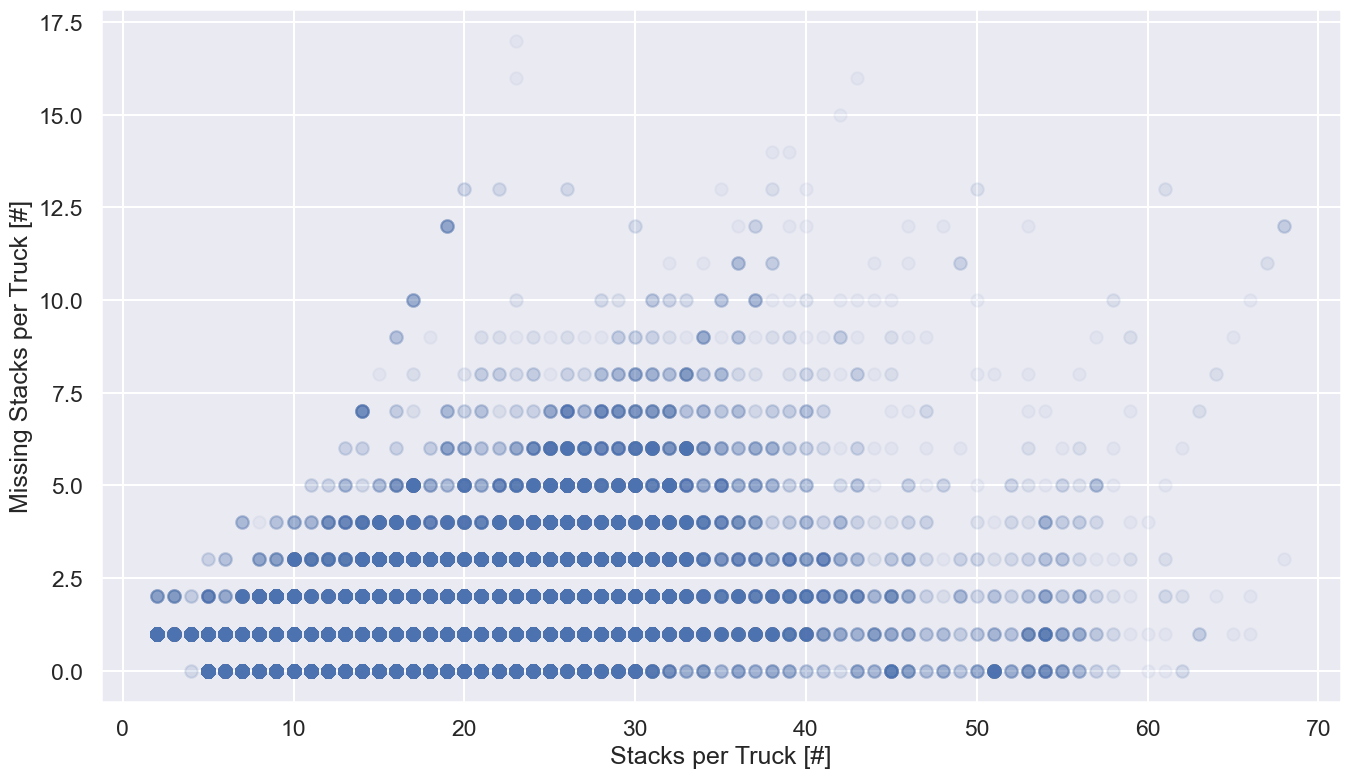

In [53]:
pattern = "Stack (\d*) with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
y = df["raw"].str.extract_all(pattern)#.map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
y = y.map_elements(lambda x: max(int(i.split(" ")[1]) for i in x))

plt.figure(figsize=(16, 9))
plt.scatter(y, x.list.len(), alpha=0.05);
plt.xlabel("Stacks per Truck [#]")
plt.ylabel("Missing Stacks per Truck [#]");

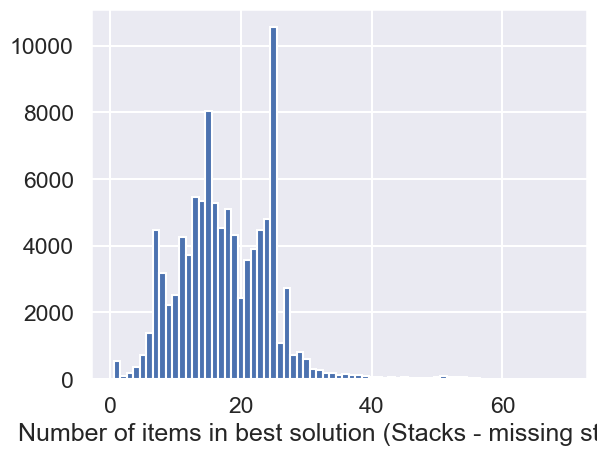

In [58]:
plt.hist(y-x.list.len(), bins=np.arange(0, 70, 1)+0.5);
plt.xlabel("Number of items in best solution (Stacks - missing stacks)");

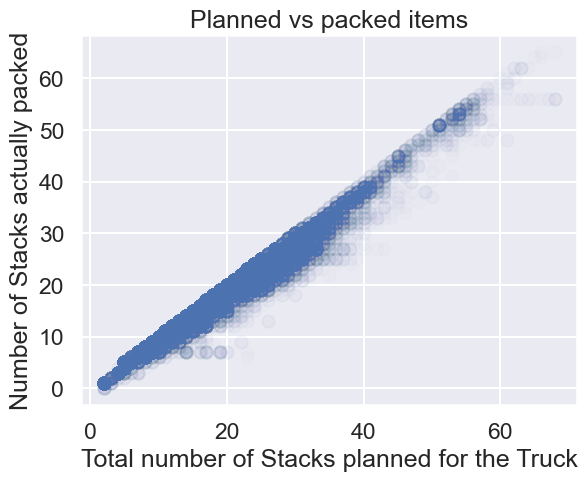

In [61]:
plt.scatter(y, y-x.list.len(), alpha=0.01);
plt.title("Planned vs packed items");
plt.xlabel("Total number of Stacks planned for the Truck")
plt.ylabel("Number of Stacks actually packed");

In [24]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

x["total_stacks"].max()

69

In [25]:
import plotly.express as px

# https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

px.scatter(
    x,
    y="total_stacks",
    x="total_items",
    opacity = 0.1
)